# **Time Series and Finance**

_These notebooks are for demonstration purposes. Time series modelling of any kind becomes much more involved and expansive based on real life projects._

In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from scipy.stats import shapiro, probplot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Setup
data = 'data/'

class CFG:
    img_dim1 = 12
    img_dim2 = 7
    fontsize = 8
    marker = 2
    lines = 1.5

# plt.rcParams.keys() to list params
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2),
                     'font.size': (CFG.fontsize),
                     'lines.markersize': (CFG.marker),
                     'lines.linewidth': (CFG.lines)})   

## **Volatility Clustering**

Continuing with the `Tata Steel` dataset from the previous NB in the series, let's model one of the most challenging aspects of financial data i.e. **volatility**, especially as it pertains to stocks and financial markets. 

The subject of finanical volatility is an entire field of study for obvious reasons. But, for starters, we can plot the volume weighted average price of the aforementioned stock and observe the oscillations over a relatively long time horizon. Here large oscillations are indicative of high volatility and periods of turbulance.

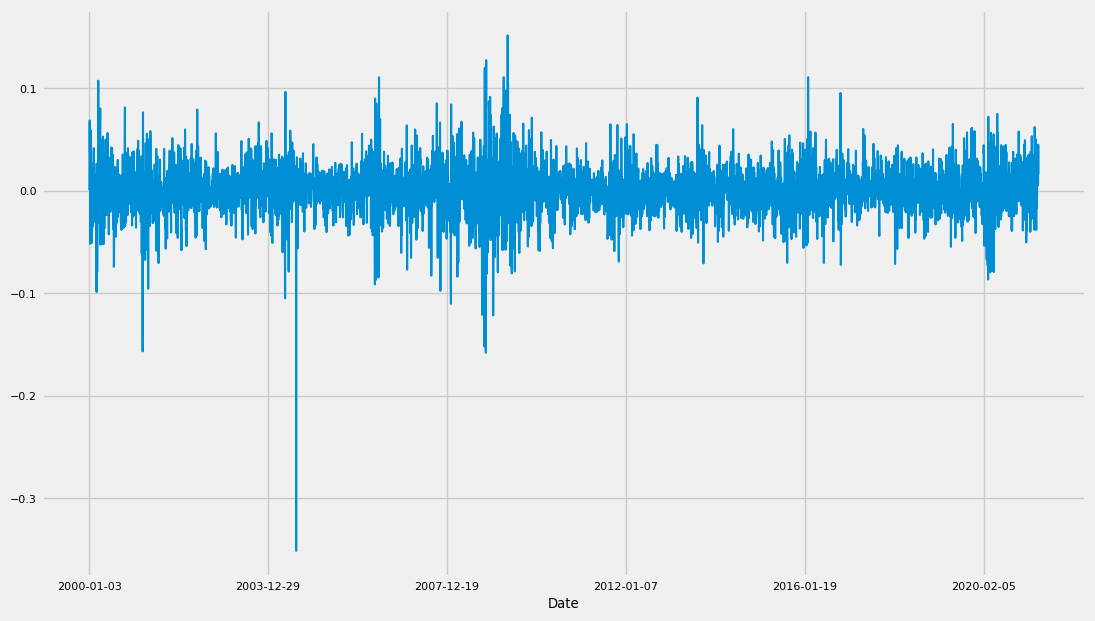

In [3]:
stock = 'TATASTEEL'
df = pd.read_csv('data/nifty50-stocks/' + stock + '.csv')
df.set_index('Date', drop=False, inplace=True)

df.VWAP.pct_change().plot();

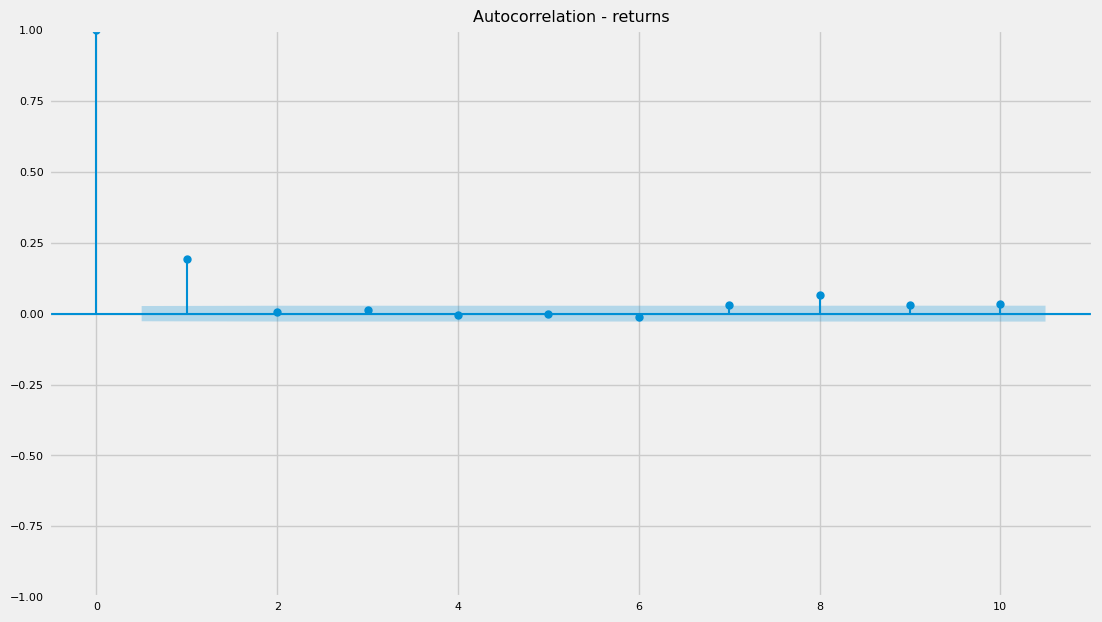

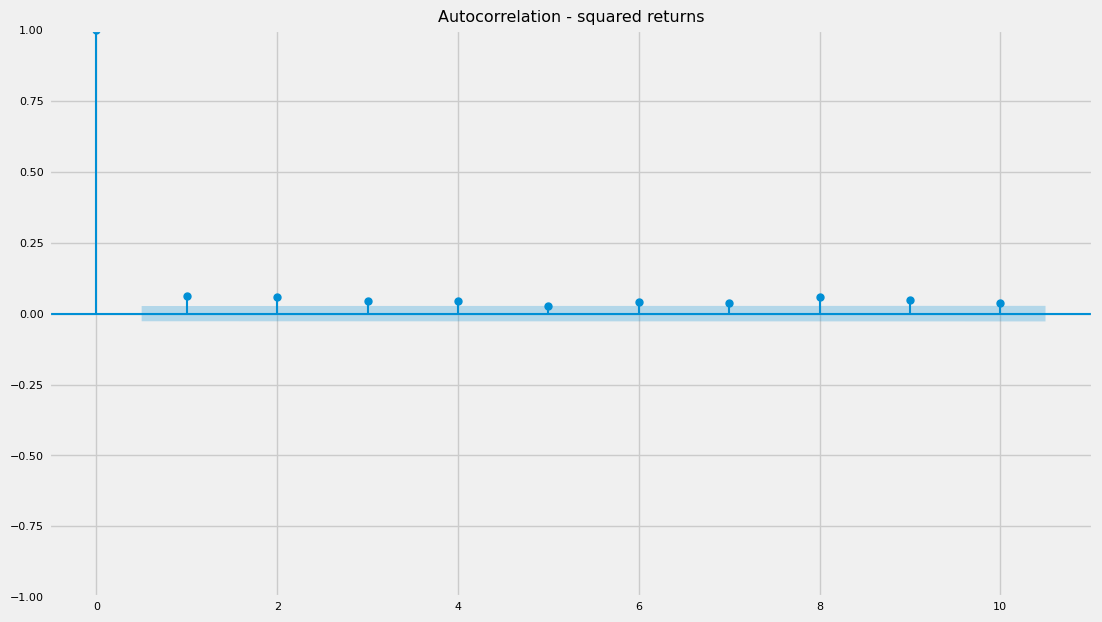

In [4]:
# Dropping nulls and plotting acf for returns and squared returns
df1 = np.log1p(df.VWAP).diff().dropna()

plot_acf(df1, lags=10, title='Autocorrelation - returns'); print()
plot_acf(df1**2, lags=10, title='Autocorrelation - squared returns'); print()

- Autocorr. on `returns` helps us determine if there is a linear dependance in the actual values of the series.
- Doing the same for `squared returns` gives a diagnostic view into serial dependance.

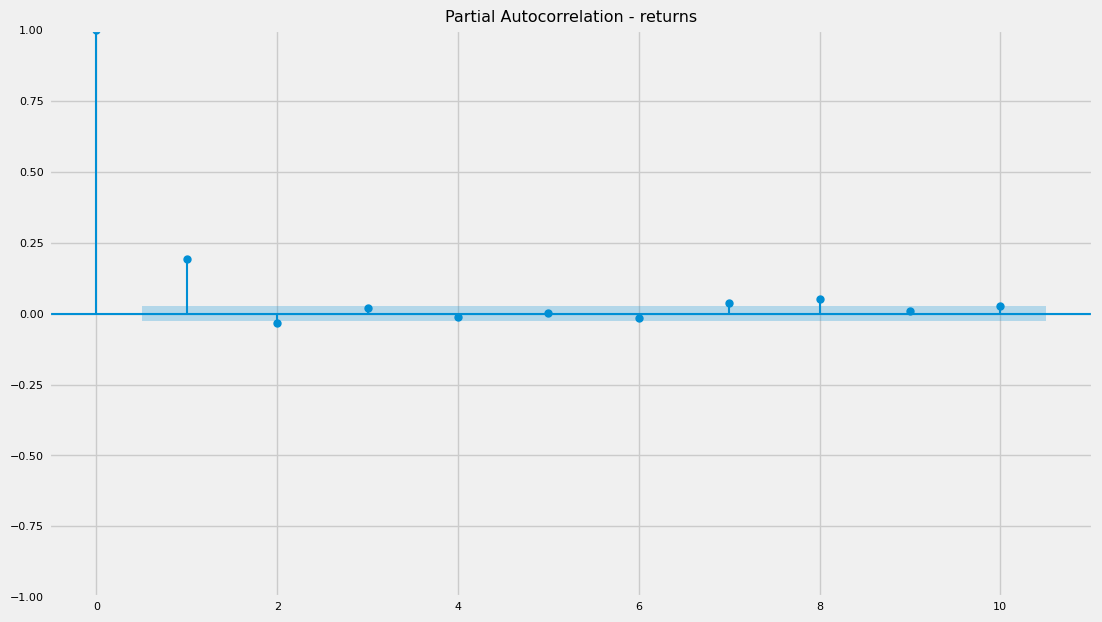

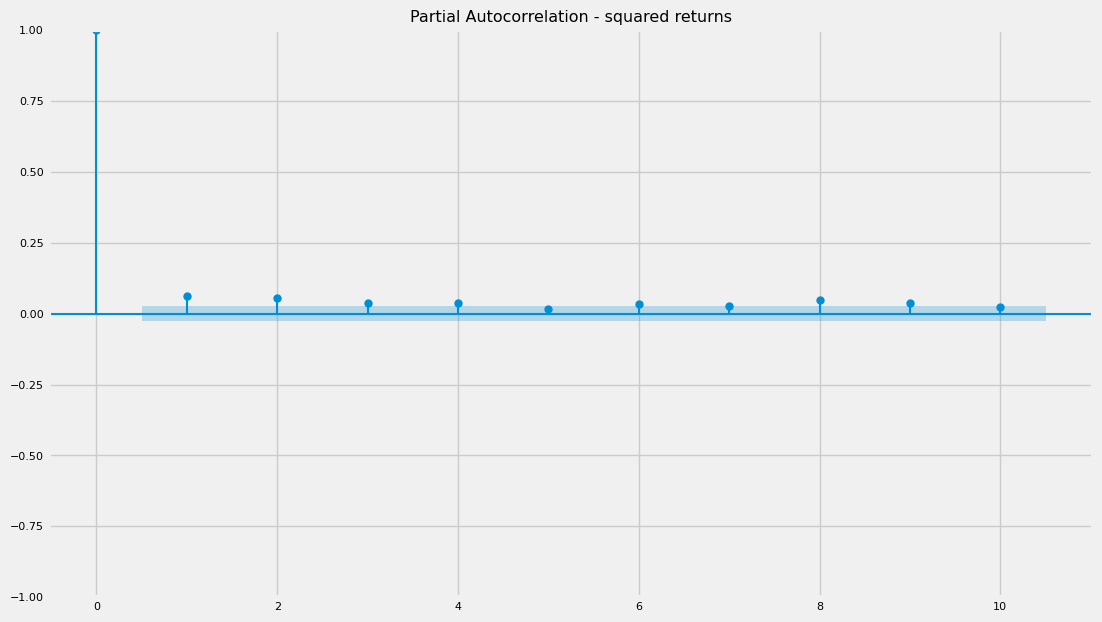

In [5]:
# Now plotting pacf
plot_pacf(df1, lags=10, title='Partial Autocorrelation - returns'); print()
plot_pacf(df1**2, lags=10, title='Partial Autocorrelation - squared returns'); print()

So, we've established that the VWAP for the stock has serial dependance.

## **Application of Mean and Variance Models**

We will apply logic similar to that from the previous NB i.e. a linear model can be specified to predict expected values. Here we will attempt to model variance of the residuals from another model and not the target values themselves.

### ARCH (Auto-Regressive Conditional Heteroskedasticity)

According to [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity):

> In econometrics, the autoregressive conditional heteroskedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms; often the variance is related to the squares of the previous innovations.
>
> let **$\epsilon_t$** denote the error terms (return residuals, with respect to a mean process), i.e. the series terms. These **$\epsilon_t$** are split into a stochastic piece **$z_t$** and a time-dependent standard deviation **$\sigma_t$** characterizing the typical size of the terms so that:
>
> $$\epsilon_t=\sigma_t z_t$$
>
> The random variable **$z_t$** is a strong white noise process. The series **$\sigma_t^2$** is modeled by:
>
>$$\sigma_t^2=\alpha_0+\alpha_1 \epsilon_{t-1}^2+\cdots+\alpha_q \epsilon_{t-q}^2 = \alpha_0 + \sum_{i=1}^q \alpha_{i} >\epsilon_{t-i}^2$$
>
> where **$\alpha_0>0$** and **$\alpha_i\ge 0,~i>0$**.

Also: 

- AR(p) model: the current value (mean / expectation) of the series depends on p
previous timesteps values
- ARCH(p): the variance of the current time step is dependent on p
lagged squared standard error terms. The standard error is the difference between the observed and predicted value from another model.
- The model is estimated with OLS.
- Lagrange multiplier test.

In [6]:
am = arch_model(100 * df1, p=1, q=0) # Scaling by 100 to account for very small floating point values.
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 12129.135691668853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12129.1066722275
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -12129.1
Distribution:                  Normal   AIC:                           24264.2
Method:            Maximum Likelihood   BIC:                           24283.9
                                        No. Observations:                 5305
Date:                Tue, Aug 27 2024   Df Residuals:                     5304
Time:                        15:41:42   Df Model:                            1
          

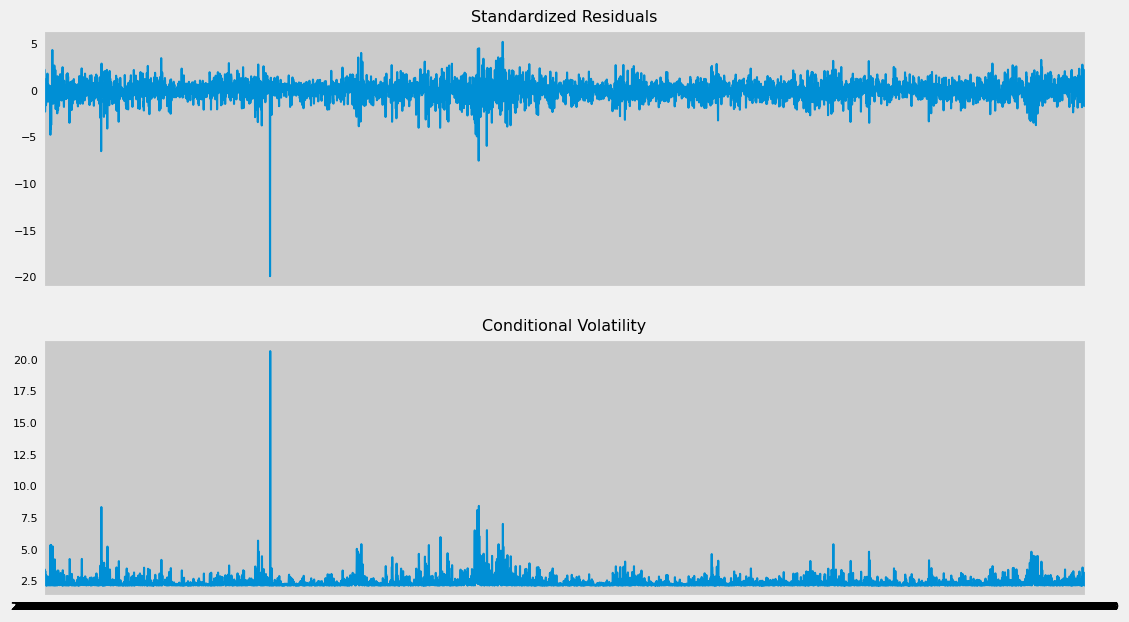

In [7]:
res.plot(); print()

Here the variance of the noise component is **not** constant over time, which is a depature from the underlying assumption used with ARIMA models. 

So different moments over the modelled time horizon have differing volatility and this sort of data is better suited for the GARCH model.

In [8]:
max_lags = 5
residuals = res.resid
st_residuals = np.divide(res.resid, res.conditional_volatility)

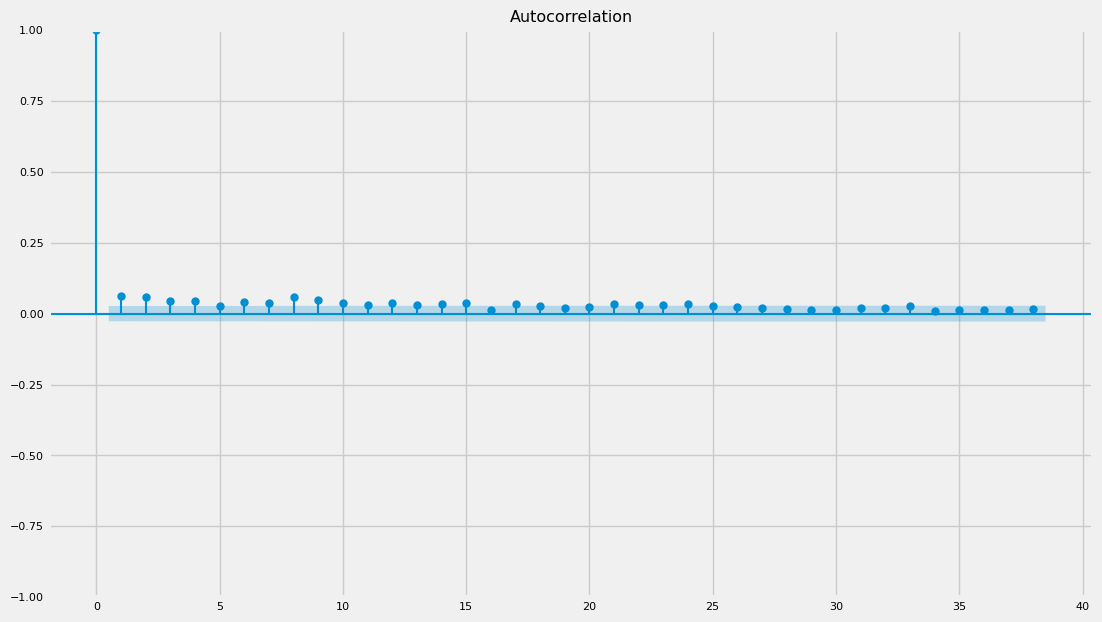

In [9]:
plot_acf(df1**2); print()

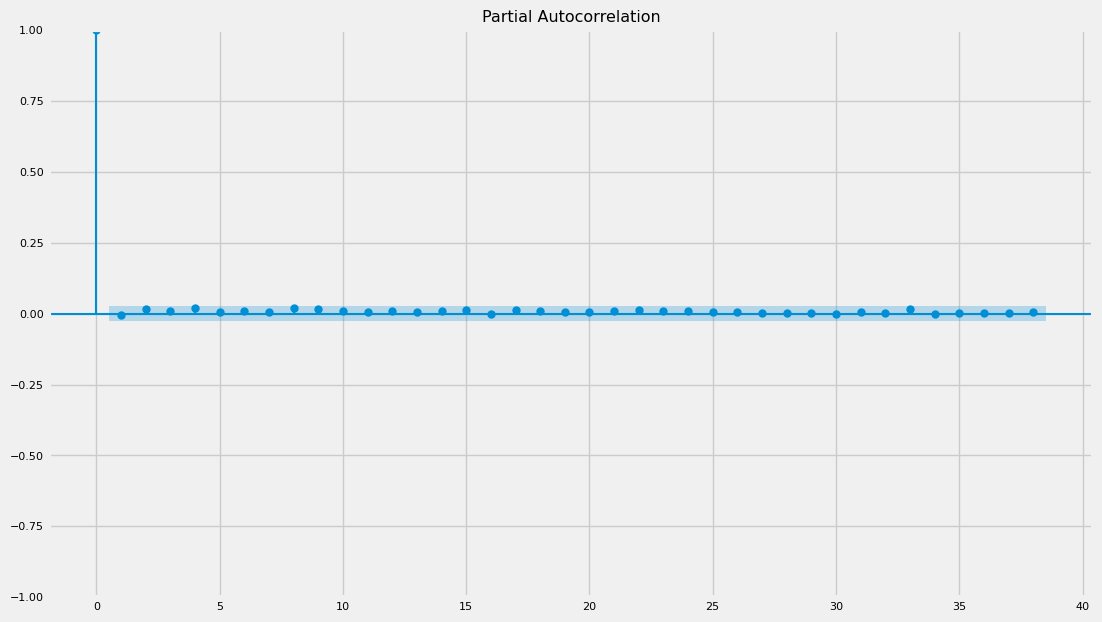

In [10]:
plot_pacf(st_residuals**2); print()

**Ljung-Box** is a test for autocorrelation and can be used in tandem with ACF and PACF.

Here $H_{0}$ posits that the data is independently distributed with no autocorrelation and $H_{1}$ posits that there is serial correlation.

**Engle ARCH** uses Ljung-Box and a Lagrange Multiplier test to determine is our ARCH model has captured heteroskedasticity.

In [11]:
# Ljung Box test for autocorrelation in residuals
lb_test = acorr_ljungbox(df1**2, lags=max_lags)
lb_test
#for lag in range(max_lags):
#    print('lag: ' + str(lag) + 'p-val: ' + str(np.round(lb_test[lag], 4)))

,lb_stat,lb_pvalue
1,19.964970,7.887399e-06
2,38.996594,3.404060e-09
3,49.365869,1.090274e-10
4,59.783425,3.221337e-12
5,63.367823,2.442687e-12


In [12]:
lb_test = acorr_ljungbox(st_residuals**2, lags=max_lags)
lb_test

,lb_stat,lb_pvalue
1,0.077508,0.780703
2,1.679658,0.431784
3,2.051796,0.561726
4,4.044199,0.400057
5,4.262313,0.512300


In [13]:
# Engle ARCG test
etest = het_arch(df1, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1], 4)))
print('pval F-test: ' + str(np.round(etest[1], 4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [14]:
# Engle ARCG test for resids
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1], 4)))
print('pval F-test: ' + str(np.round(etest[1], 4)))

pval Lagrange: 0.5195
pval F-test: 0.5195


### GARCH Models (Generalized ARCH)

> GARCH is an extension of ARCH if an ARMA model is assumed for the error variance. The formula is:
>
>$$ \sigma_t^2=\omega + \alpha_1 \epsilon_{t-1}^2 + \cdots + \alpha_q \epsilon_{t-q}^2 + \beta_1 \sigma_{t-1}^2 + \cdots + \beta_p\sigma_{t->p}^2 = \omega + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{i=1}^p \beta_i \sigma_{t-i}^2 $$
>
> Where $p$ is the order of the GARCH terms $\sigma^2$ and $q$ is the order of the ARCH terms **$\epsilon^2$**

In [15]:
# Starting with p,q order (1,1)
gm = arch_model(100 * df1, p=1, q=1)
res = gm.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 11838.126029106981
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11835.563882450348
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11835.56177652276
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11835.6
Distribution:                  Normal   AIC:                           23679.1
Method:            Maximum Likelihood   BIC:                           23705.4
                                        No. Observations:                 5305
Date:                Tue, Aug 27 2024   Df Residuals:                     5304
Time:        

In [16]:
## Ljung Box test
residuals = res.resid
st_residuals = np.divide(residuals, res.conditional_volatility)
lb_test = acorr_ljungbox(df1**2, lags=max_lags)
lb_test.round(4)

,lb_stat,lb_pvalue
1,19.9650,0.0
2,38.9966,0.0
3,49.3659,0.0
4,59.7834,0.0
5,63.3678,0.0


In [17]:
# Doing the same for squared residuals
lb_test = acorr_ljungbox(st_residuals**2, lags=max_lags)
lb_test.round(4)

,lb_stat,lb_pvalue
1,0.1794,0.6719
2,0.2727,0.8725
3,0.3143,0.9573
4,0.3185,0.9886
5,0.3491,0.9966


In [18]:
# Engle ARCH
etest = het_arch(df1, maxlag=5)
print('p-val Lagrange: ' + str(np.round(etest[1], 4)))
#print('p-val F-test: ' + str(np.round(etest[1], 4)))

p-val Lagrange: 0.0


In [19]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
#print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.9966


`NOTE` The value similarity for both Lagrange multipliers and F-test is probably due to artifacts being introduced by the library. This warrants some deep diving and tinkering.

### GARCH Extension Examples

GARCH models have numerous extensions which are purpose built for a variety of scenarios. For example:

**GJR-GARCH**: The Glosten-Jagannathan-Runkle GARCH (GJR-GARCH) models asymmetry in the ARCH process. This is usually asymmetric negative shocks / asymmetric dependence.

**TGARCH**:  The Threshold GARCH (TGARCH) is similar to GJR GARCH. The specification is one on conditional standard deviation instead of conditional variance.

### ARMA-GARCH

Uptil now we have assumed a constant mean throughout the time-series, even if there are two or more than two moments. This is sually never reflective of reality.

We should be able to model both the conditional mean and the conditional variance through joint estimation using ARIMA and GARCH. For considerations related to statistical consistency, the sequence of modelling ARIMA and then GARCH needs to be respected.

The `arch` library has these considerations built into it.

In [20]:
from arch.univariate import ARX

In [21]:
ar = ARX(100 * df1, lags=[1, 3]) # Scaling like before, with specific lags we want to model.
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                   VWAP   R-squared:                       0.038
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:          Constant Variance   Log-Likelihood:               -12185.4
Distribution:                  Normal   AIC:                           24378.9
Method:            Maximum Likelihood   BIC:                           24405.2
                                        No. Observations:                 5302
Date:                Tue, Aug 27 2024   Df Residuals:                     5299
Time:                        15:42:05   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0270  3.328e-02      0.810      0.418 

In [22]:
from arch.univariate import ARCH, GARCH

In [23]:
ar.volatility = GARCH(p=1, q=1) # passing the ARCH volatility property to GARCH
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:                      GARCH   Log-Likelihood:               -11726.4
Distribution:                  Normal   AIC:                           23464.8
Method:            Maximum Likelihood   BIC:                           23504.2
                                        No. Observations:                 5302
Date:                Tue, Aug 27 2024   Df Residuals:                     5299
Time:                        15:42:05   Df Model:                            3
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0116  3.169e-02      0.366      0.

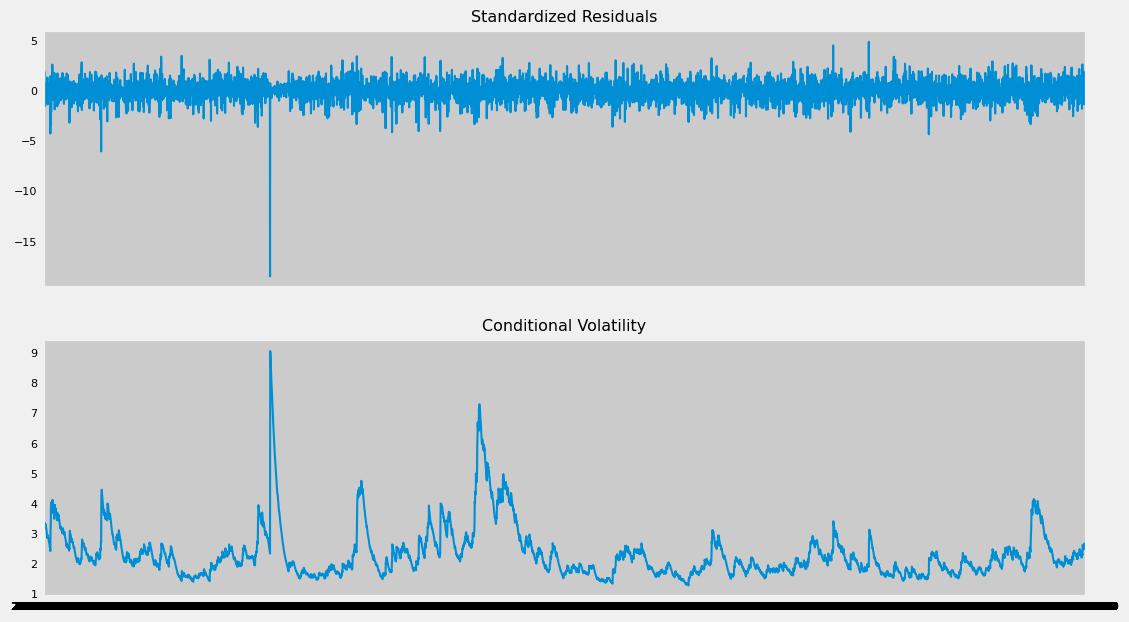

In [24]:
fig = res.plot()

## Forecasting Financials by Combining ARCH and GARCH

We have established that conditional variance (volatility), at a given time depends on past squared errors (ARCH) and past conditional variances (GARCH) in financial time series data. And since the goal is to forecast volatility instead of the mean of the time series then ARIMA won't do the job.

ARCH models, which focus on modeling the variance of the series bases on past errors, are extended using GARCH models by incorporating lagged variances. This adds to model flexibility and the ability to capture more complex volatility patterns.

In [25]:
df1 = np.log1p(df.VWAP).diff().dropna()
print(df1.index.min(), df1.index.max())

2000-01-04 2021-04-30


In [26]:
# Split to training and validation sets
xtr, xval = df1.loc[:'2021-01-01'], df1.loc['2021-01-01':]

In [27]:
# Fit the training data to the model
ar = ARX(100 * xtr, lags=[1])
ar.volatility = GARCH(p=1, q=1)
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:                      GARCH   Log-Likelihood:               -11547.9
Distribution:                  Normal   AIC:                           23105.7
Method:            Maximum Likelihood   BIC:                           23138.5
                                        No. Observations:                 5225
Date:                Tue, Aug 27 2024   Df Residuals:                     5223
Time:                        15:42:26   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      7.6358e-03  3.177e-02      0.240      0.810 

In [28]:
# Building the ARCH Model forecast
# note that the arch library is poorly integrated with the Pandas library.
xfor = res.forecast(horizon=xval.shape[0])

# Workaround for predicted values at the last timestamp
mean_forcast = xfor.mean.tail(1).values.reshape(len(xval), 1)

In [29]:
forecast = pd.DataFrame()
forecast['Date'] = xval.index
forecast['VWAP'] = xval.values
forecast['fc_mean'] = xfor.mean.tail(1).values.reshape(len(xval), 1)
forecast['fc_std'] = np.sqrt(xfor.variance.tail(1).values.reshape(len(xval), 1))

In [30]:
forecast

,Date,VWAP,fc_mean,fc_std
0,2021-01-01,-0.000635,-0.005309,1.956875
1,2021-01-04,0.044198,0.006553,2.001682
2,2021-01-05,0.013379,0.008972,2.008021
3,2021-01-06,0.003357,0.009466,2.012758
4,2021-01-07,0.048117,0.009566,2.017403
...,...,...,...,...
75,2021-04-26,0.013062,0.009592,2.293164
76,2021-04-27,0.023504,0.009592,2.296414
77,2021-04-28,0.006857,0.009592,2.299650
78,2021-04-29,0.043910,0.009592,2.302871


### Value at Risk

Value at Risk (VaR) is a statistical measure used to assess the risk of loss on a portfolio of financial assets. It estimates the maximum potential loss that an investment portfolio could suffer over a specified time period, given a certain level of confidence. 

ARCH/GARCH models can be used to estimate VaR by modeling the time-varying volatility of returns. Since VaR is sensitive to changes in volatility, using these models can provide more accurate risk estimates, particularly in periods of high market turbulence.

We will work with adjusted closing prices of the S&P 500 for this section

In [31]:
import arch.data.sp500

data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

In [32]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
res = am.fit(disp="off", last_obs="2017-12-31")

In [33]:
forecasts = res.forecast(start="2018-1-1", reindex=False)
cond_mean = forecasts.mean["2018":]
cond_var = forecasts.variance["2018":]

q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.64484999 -1.64965918]


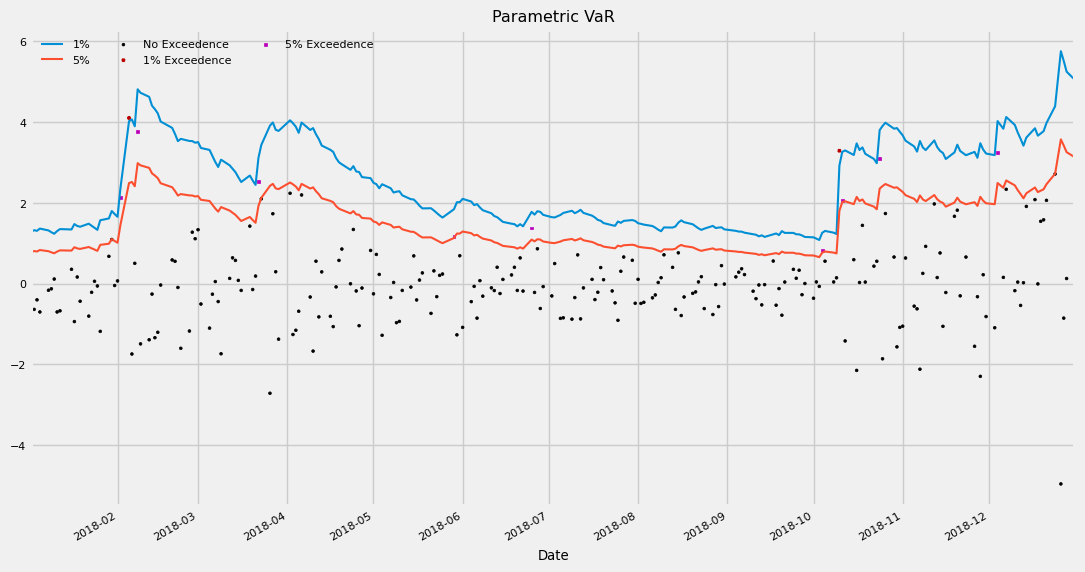

In [34]:
# Here we will model the value at risk i.e. var
var = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
var = pd.DataFrame(var, columns=["1%", "5%"], index=cond_var.index)

ax = var.plot(legend=False)
xl = ax.set_xlim(var.index[0], var.index[-1])

rets_2018 = returns["2018":].copy()
rets_2018.name = "S&P 500 Return"

c = []
for i in var.index:
    if rets_2018[i] > -var.loc[i, "5%"]:
        c.append("#000000")
    elif rets_2018[i] < -var.loc[i, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")

c = np.array(c, dtype="object")
labels = {"#BB0000": "1% Exceedence", "#BB00BB": "5% Exceedence", "#000000": "No Exceedence",}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)

- We've stuck with a period of relatively lower volatility, especially considered EVERYTHING that has happended since the end of 2019.
- `Black dots` represent historical observations over time.
- The `Red line`, is our 5% risk cut off, assuming the conditions applied for the GARCH model.
- Similarly the `Blue line` is the 1% cut off.